# Behavior Analysis: Total Instances of Behavior

Press SHIFT + ENTER to run code

### USER INPUT!

In [1]:
## Define project
project_name = 'project_ACC_MiniscopeSNI_3WeekMorphine'

# Select group and condition, see meta.py to see how you previously defined it for your project
selected_groups = ['NoInjury','SNI']
selected_conditions = ['Combined']


### Main Code: Create Bar Graph of Total Instances for Behavior

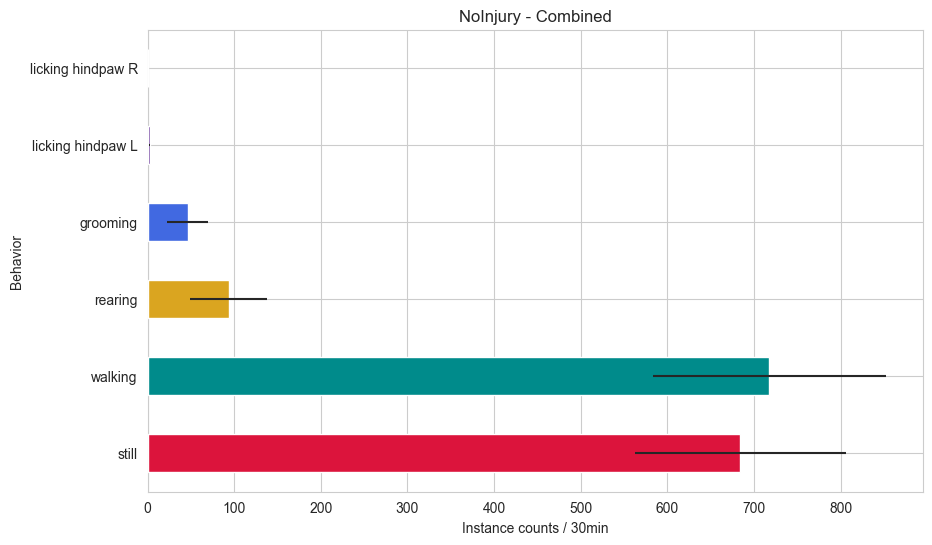

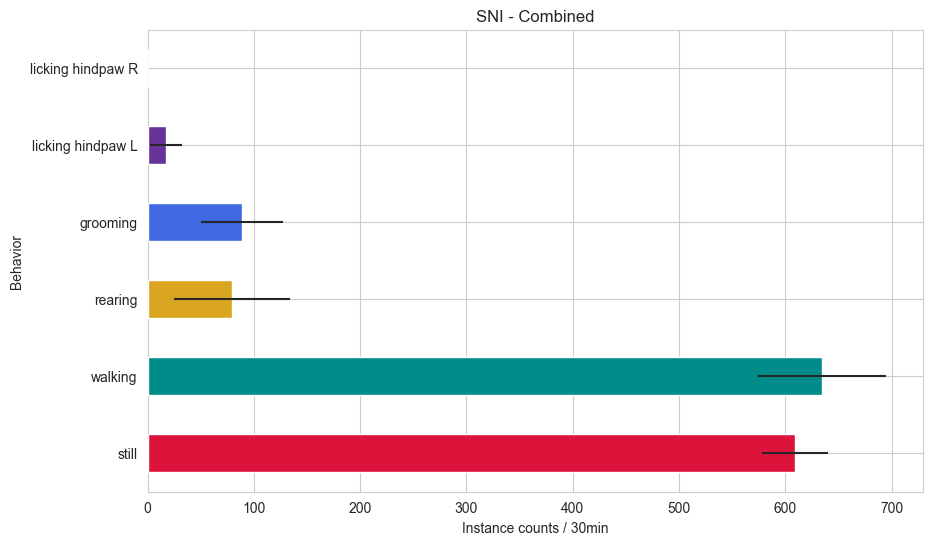

In [2]:
###### RUN DEPENDENCIES ######
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys

if not os.path.join(os.path.abspath(''), '../') in sys.path:
    sys.path.append(os.path.join(os.path.abspath(''), '../'))

from utils.classification import load_behaviors
from utils.meta import *
import warnings

###### Load Behaviors ######
behaviors = load_behaviors(f"../processed_dataset/{project_name}/behaviors_{project_name}.pkl")

# Define the directory path
directory_path = f"../processed_dataset/{project_name}/figures/behavior_instance-counts"
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

def get_num_bouts(predict, behavior_classes):
    bout_counts = []
    bout_start_idx = np.where(np.diff(np.hstack([-1, predict])) != 0)[0]
    bout_start_label = predict[bout_start_idx]
    for b, behavior_name in enumerate(behavior_classes):
        idx_b = np.where(bout_start_label == int(b))[0]
        if len(idx_b) > 0:
            bout_counts.append(len(idx_b))
        else:
            bout_counts.append(np.nan)  # Use np.nan for missing data
    return bout_counts

# Iterate over groups and conditions
for selected_condition in selected_conditions:
    for selected_group in selected_groups:
        bout_counts = []
        
        # Check if the group and condition exist in behaviors
        if selected_group in behaviors and selected_condition in behaviors[selected_group]:
            file_keys = list(behaviors[selected_group][selected_condition].keys())
            
            for file_name in file_keys:
                bout_counts.append(get_num_bouts(behaviors[selected_group][selected_condition][file_name], behavior_names))
            
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                bout_mean = np.nanmean(bout_counts, axis=0)
                bout_std = np.nanstd(bout_counts, axis=0)
            
            # Create DataFrame for the behavior data
            behavior_instance_dict = {
                'mean_counts': bout_mean,
                'std_counts': bout_std,
                'labels': behavior_names,
                'colors': behavior_colors,
            }
            behavior_instance_df = pd.DataFrame(behavior_instance_dict)
            
            # Save the DataFrame
            csv_filename = f"../processed_dataset/{project_name}/figures/behavior_instance-counts/behavior_instance_counts_{project_name}_{selected_group}-{selected_condition}.csv"
            behavior_instance_df.to_csv(csv_filename)

            # Plot the data
            fig, ax = plt.subplots(figsize=(10, 6))
            behavior_instance_df.plot.barh(
                y='mean_counts',
                x='labels',
                xerr='std_counts',
                color=behavior_colors,
                legend=False,
                ax=ax,
                zorder=3
            )
            
            # Add titles and grid
            ax.set_title(f'{selected_group} - {selected_condition}')
            ax.set_xlabel('Instance counts / 30min')
            ax.set_ylabel('Behavior')
            ax.grid(True, zorder=0)
            
            # Save the plot
            fig.savefig(f"../processed_dataset/{project_name}/figures/behavior_instance-counts/behavior_counts_{project_name}_{selected_group}_{selected_condition}.svg",
                        dpi=600, bbox_inches='tight')
            plt.show()
        else:
            print(f"No data found for {selected_group} under condition {selected_condition}")

# ANALYSIS COMPLETE!

## Additional Analysis: Raw Frequency of Behavioral Bouts

/Users/justinjames/GitHub/LUPE-2.0/venv/lib/python3.9/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/justinjames/GitHub/LUPE-2.0/venv/lib/python3.9/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/justinjames/GitHub/LUPE-2.0/venv/lib/python3.9/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/justinjames/GitHub/LUPE-2.0/venv/lib/python3.9/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions =

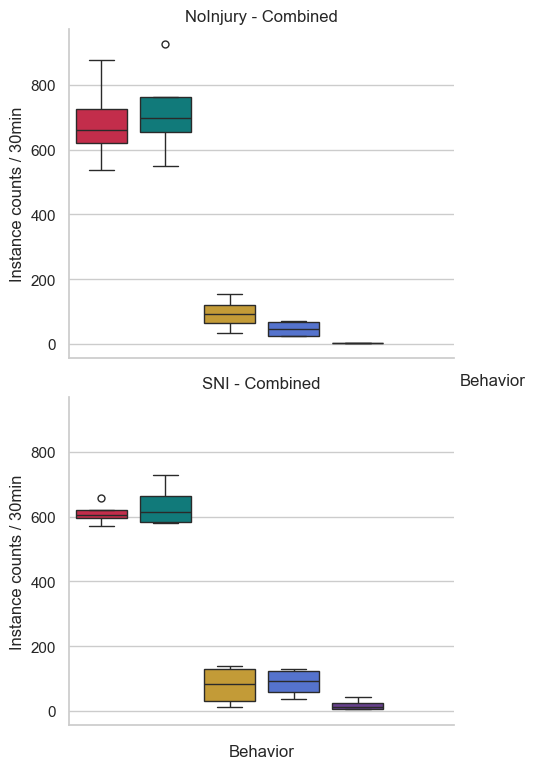

In [3]:
import warnings
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns


raw_directory_path = f"../processed_dataset/{project_name}/figures/behavior_instance-counts/behavior_instance-counts_raw"
if not os.path.exists(raw_directory_path):
    os.makedirs(raw_directory_path)

all_data = []

for selected_group in selected_groups:
    for selected_condition in selected_conditions:
        if selected_group in behaviors and selected_condition in behaviors[selected_group]:
            file_keys = list(behaviors[selected_group][selected_condition].keys())
            
            bout_counts = []
            for file_name in file_keys:
                per_file_bout_counts = get_num_bouts(behaviors[selected_group][selected_condition][file_name], behavior_names)
                bout_counts.append(per_file_bout_counts)
                
                for behavior, count in zip(behavior_names, per_file_bout_counts):
                    all_data.append({
                        'Group': selected_group,
                        'Condition': selected_condition,
                        'File': file_name,
                        'Behavior': behavior,
                        'Count': count
                    })
            
            raw_bout_counts_df = pd.DataFrame(bout_counts, columns=behavior_names, index=file_keys)

            raw_csv_filename = f"{raw_directory_path}/behavior_instance_counts_raw_{project_name}_{selected_group}-{selected_condition}.csv"
            raw_bout_counts_df.to_csv(raw_csv_filename)

            # Compute mean and std for quick check
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                bout_mean = np.nanmean(bout_counts, axis=0)
                bout_std = np.nanstd(bout_counts, axis=0)

all_data_df = pd.DataFrame(all_data)

# Summary plot
sns.set(style="whitegrid")
g = sns.catplot(
    data=all_data_df,
    x='Behavior',
    y='Count',
    hue='Behavior',
    col='Condition',
    row='Group',
    kind='box',
    height=4,
    aspect=1.2,
    palette=behavior_colors if 'behavior_colors' in globals() else 'Set2'
)

g.set_titles("{row_name} - {col_name}")
g.set_axis_labels("Behavior", "Instance counts / 30min")

# Rotate x-axis behavior labels vertically
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Save the figure
summary_figure_path = f"../processed_dataset/{project_name}/figures/behavior_instance-counts/behavior_instance-counts_raw/behavior_instance_counts_raw_summary_{project_name}.svg"
plt.savefig(summary_figure_path, dpi=300, format='svg', bbox_inches='tight')
plt.show()